In [1]:
import xarray
import hvplot.xarray
import sunpy.map
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ImageNormalize, SqrtStretch

In [43]:
def subtract_background(cube, threshold=None):
    if threshold is not None:
        # Interpolate over masked values
        cube_thresh = xarray.where(cube <= threshold, np.nan, cube).interpolate_na('s_perp').interpolate_na('s_parallel')
    else:
        cube_thresh = cube
    c1 = (cube_thresh[...,-1] - cube_thresh[...,0]) / (cube_thresh.s_perp[-1] - cube_thresh.s_perp[0]) 
    c0 = cube_thresh[...,0] - c1 * cube_thresh.s_perp[0]
    bg = c1 * cube_thresh.s_perp + c0
    cube_no_bg = cube - bg
    return xarray.where(cube_no_bg<0, np.nan, cube_no_bg)

## EIS

In [2]:
eis_ds = xarray.open_dataset('../pipeline/data/EIS/loop_cutouts_no_background.nc')

In [3]:
eis_ds.keys()

KeysView(<xarray.Dataset>
Dimensions:                    (s_parallel: 239, s_perp: 45)
Coordinates:
  * s_parallel                 (s_parallel) float64 0.0 1.0 2.0 ... 372.7 373.7
  * s_perp                     (s_perp) float64 0.0 1.023 2.045 ... 43.98 45.0
Data variables: (12/38)
    Al IX 284.015_intensity    (s_parallel, s_perp) float64 ...
    Ar XI 188.806_intensity    (s_parallel, s_perp) float64 ...
    Ar XIV 187.964_intensity   (s_parallel, s_perp) float64 ...
    Ar XIV 194.396_intensity   (s_parallel, s_perp) float64 ...
    Ca XIV 193.874_intensity   (s_parallel, s_perp) float64 ...
    Ca XV 200.972_intensity    (s_parallel, s_perp) float64 ...
    ...                         ...
    O V 192.906_intensity      (s_parallel, s_perp) float64 ...
    S XI 188.675_intensity     (s_parallel, s_perp) float64 ...
    S XIII 256.686_intensity   (s_parallel, s_perp) float64 ...
    Si VII 275.368_intensity   (s_parallel, s_perp) float64 ...
    Si VII 275.665_intensity   (s_paralle

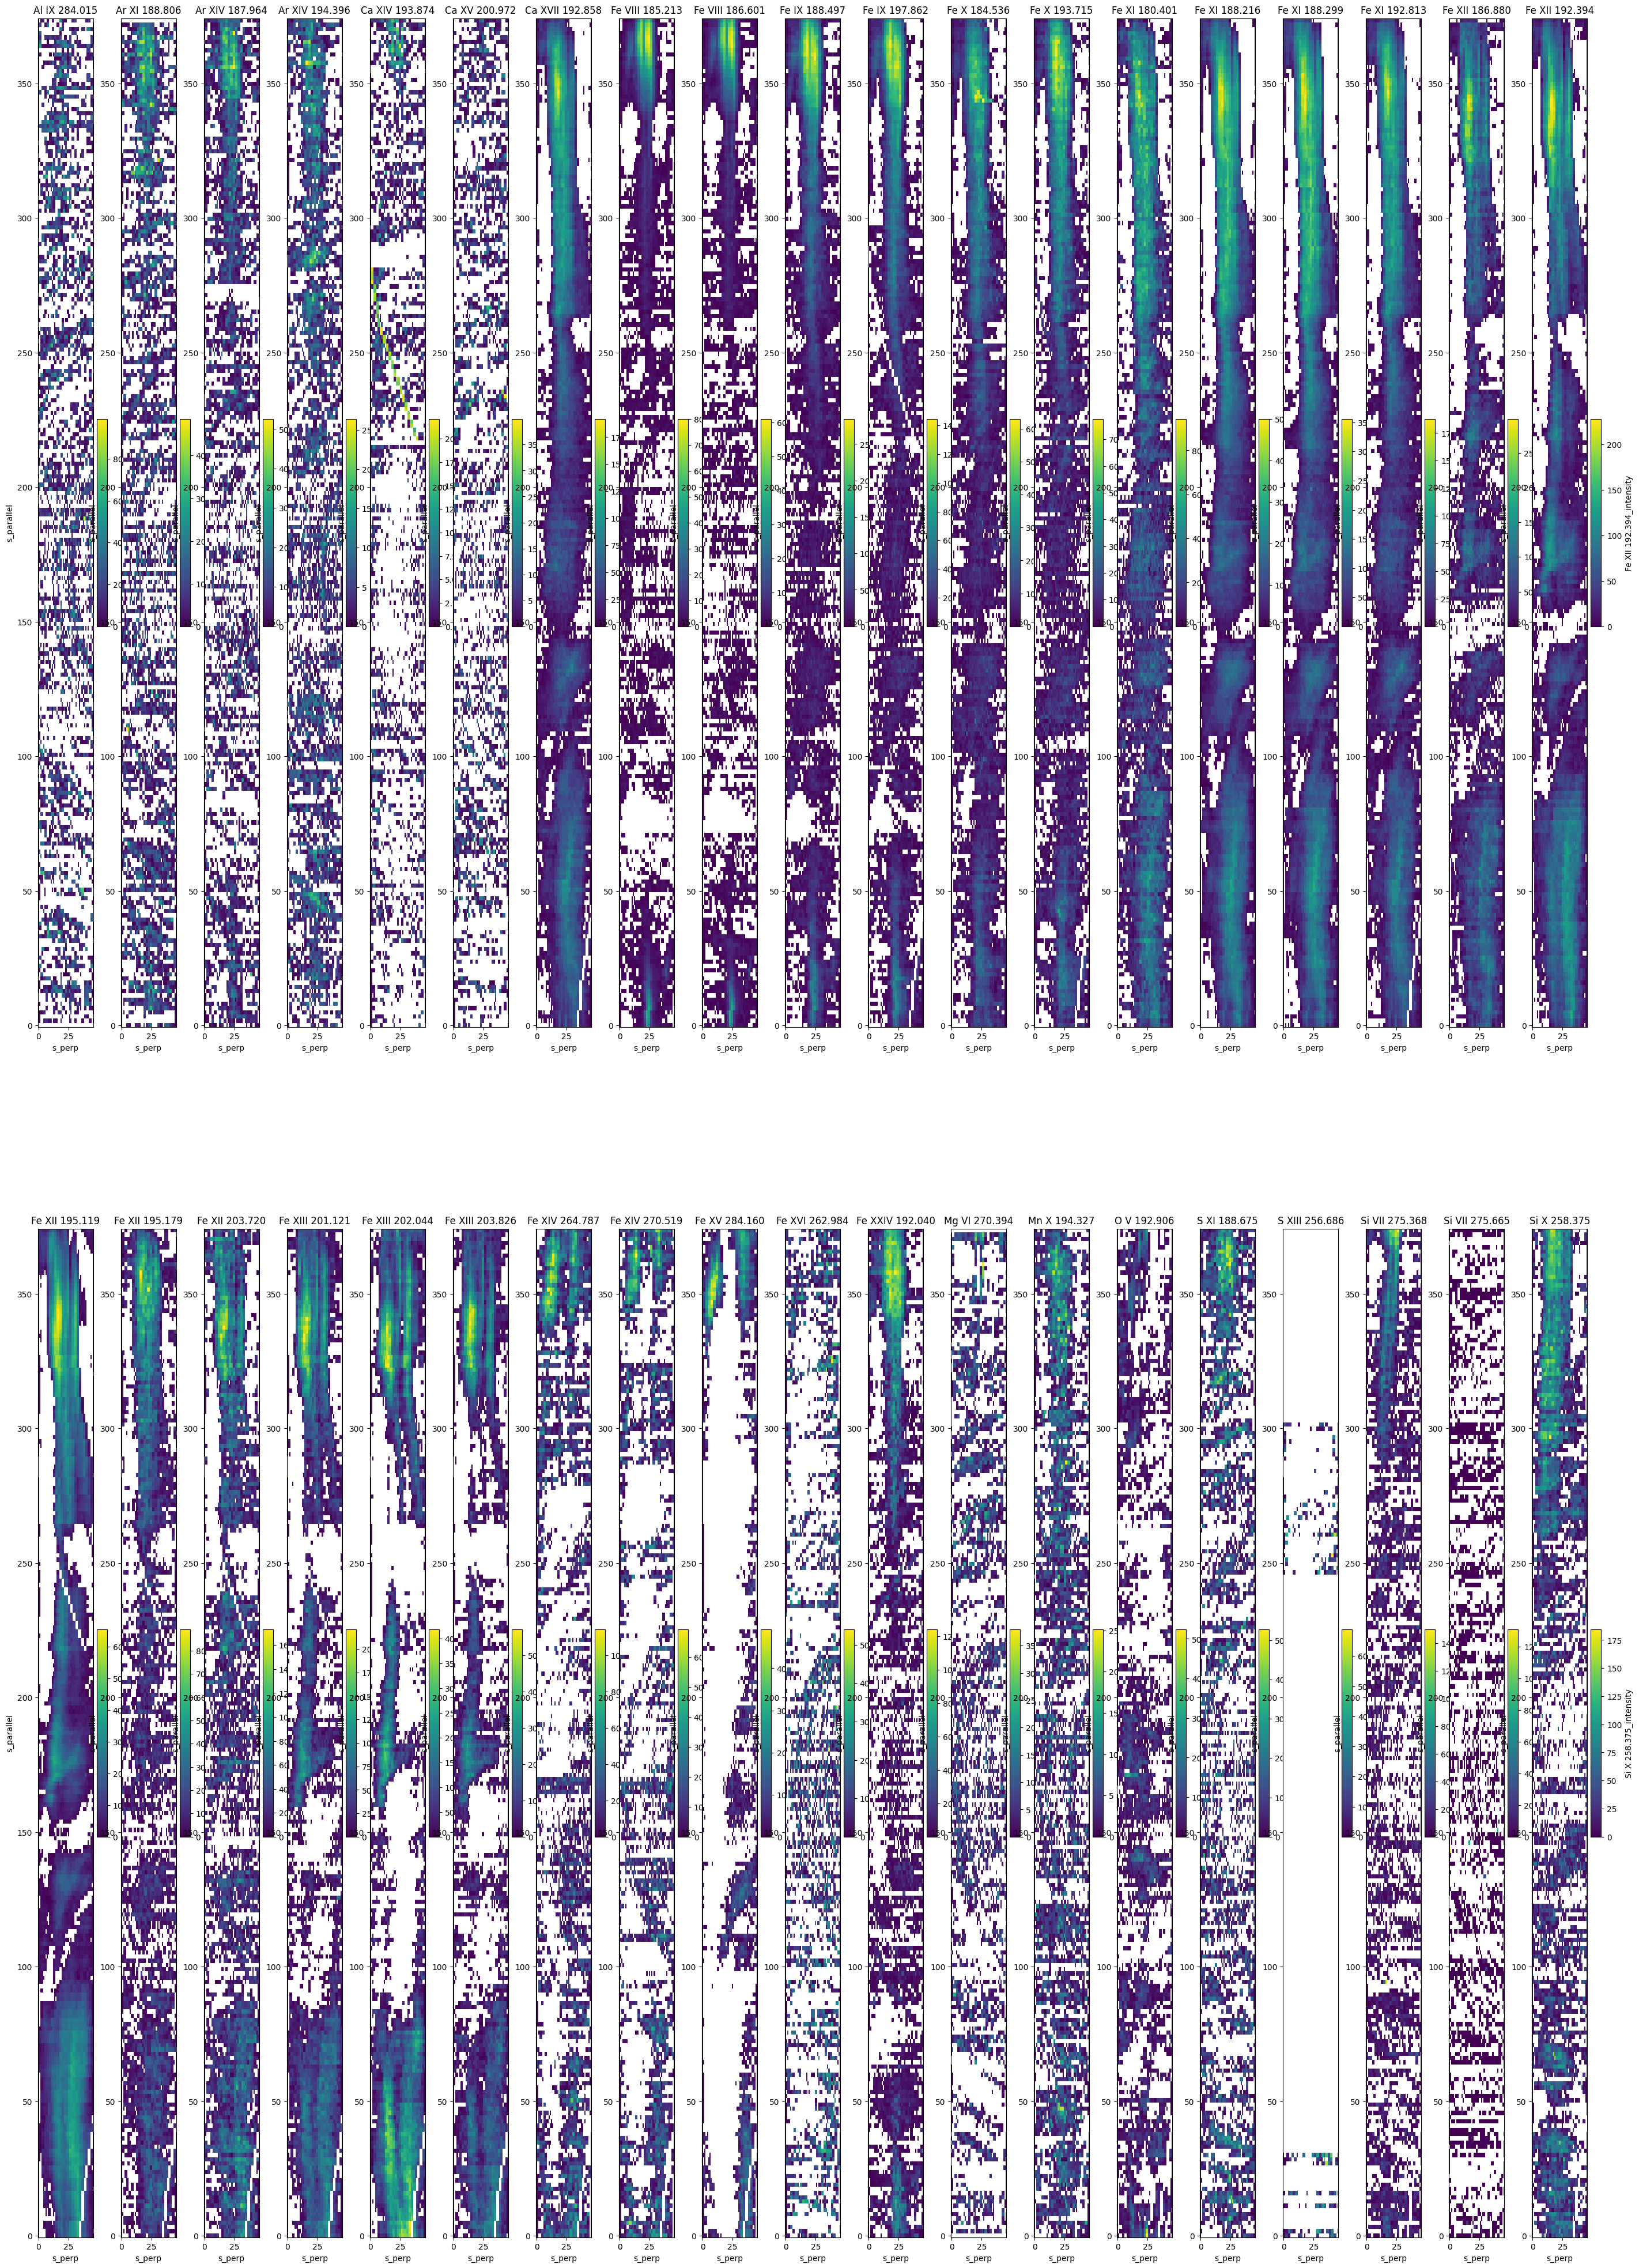

In [4]:
fig = plt.figure(figsize=(35, 50))
for i,k in enumerate(eis_ds.keys()):
    ax = fig.add_subplot(2, 19, i+1)
    eis_ds[k].plot.imshow(ax=ax)
    ax.set_title(k.split('_')[0])

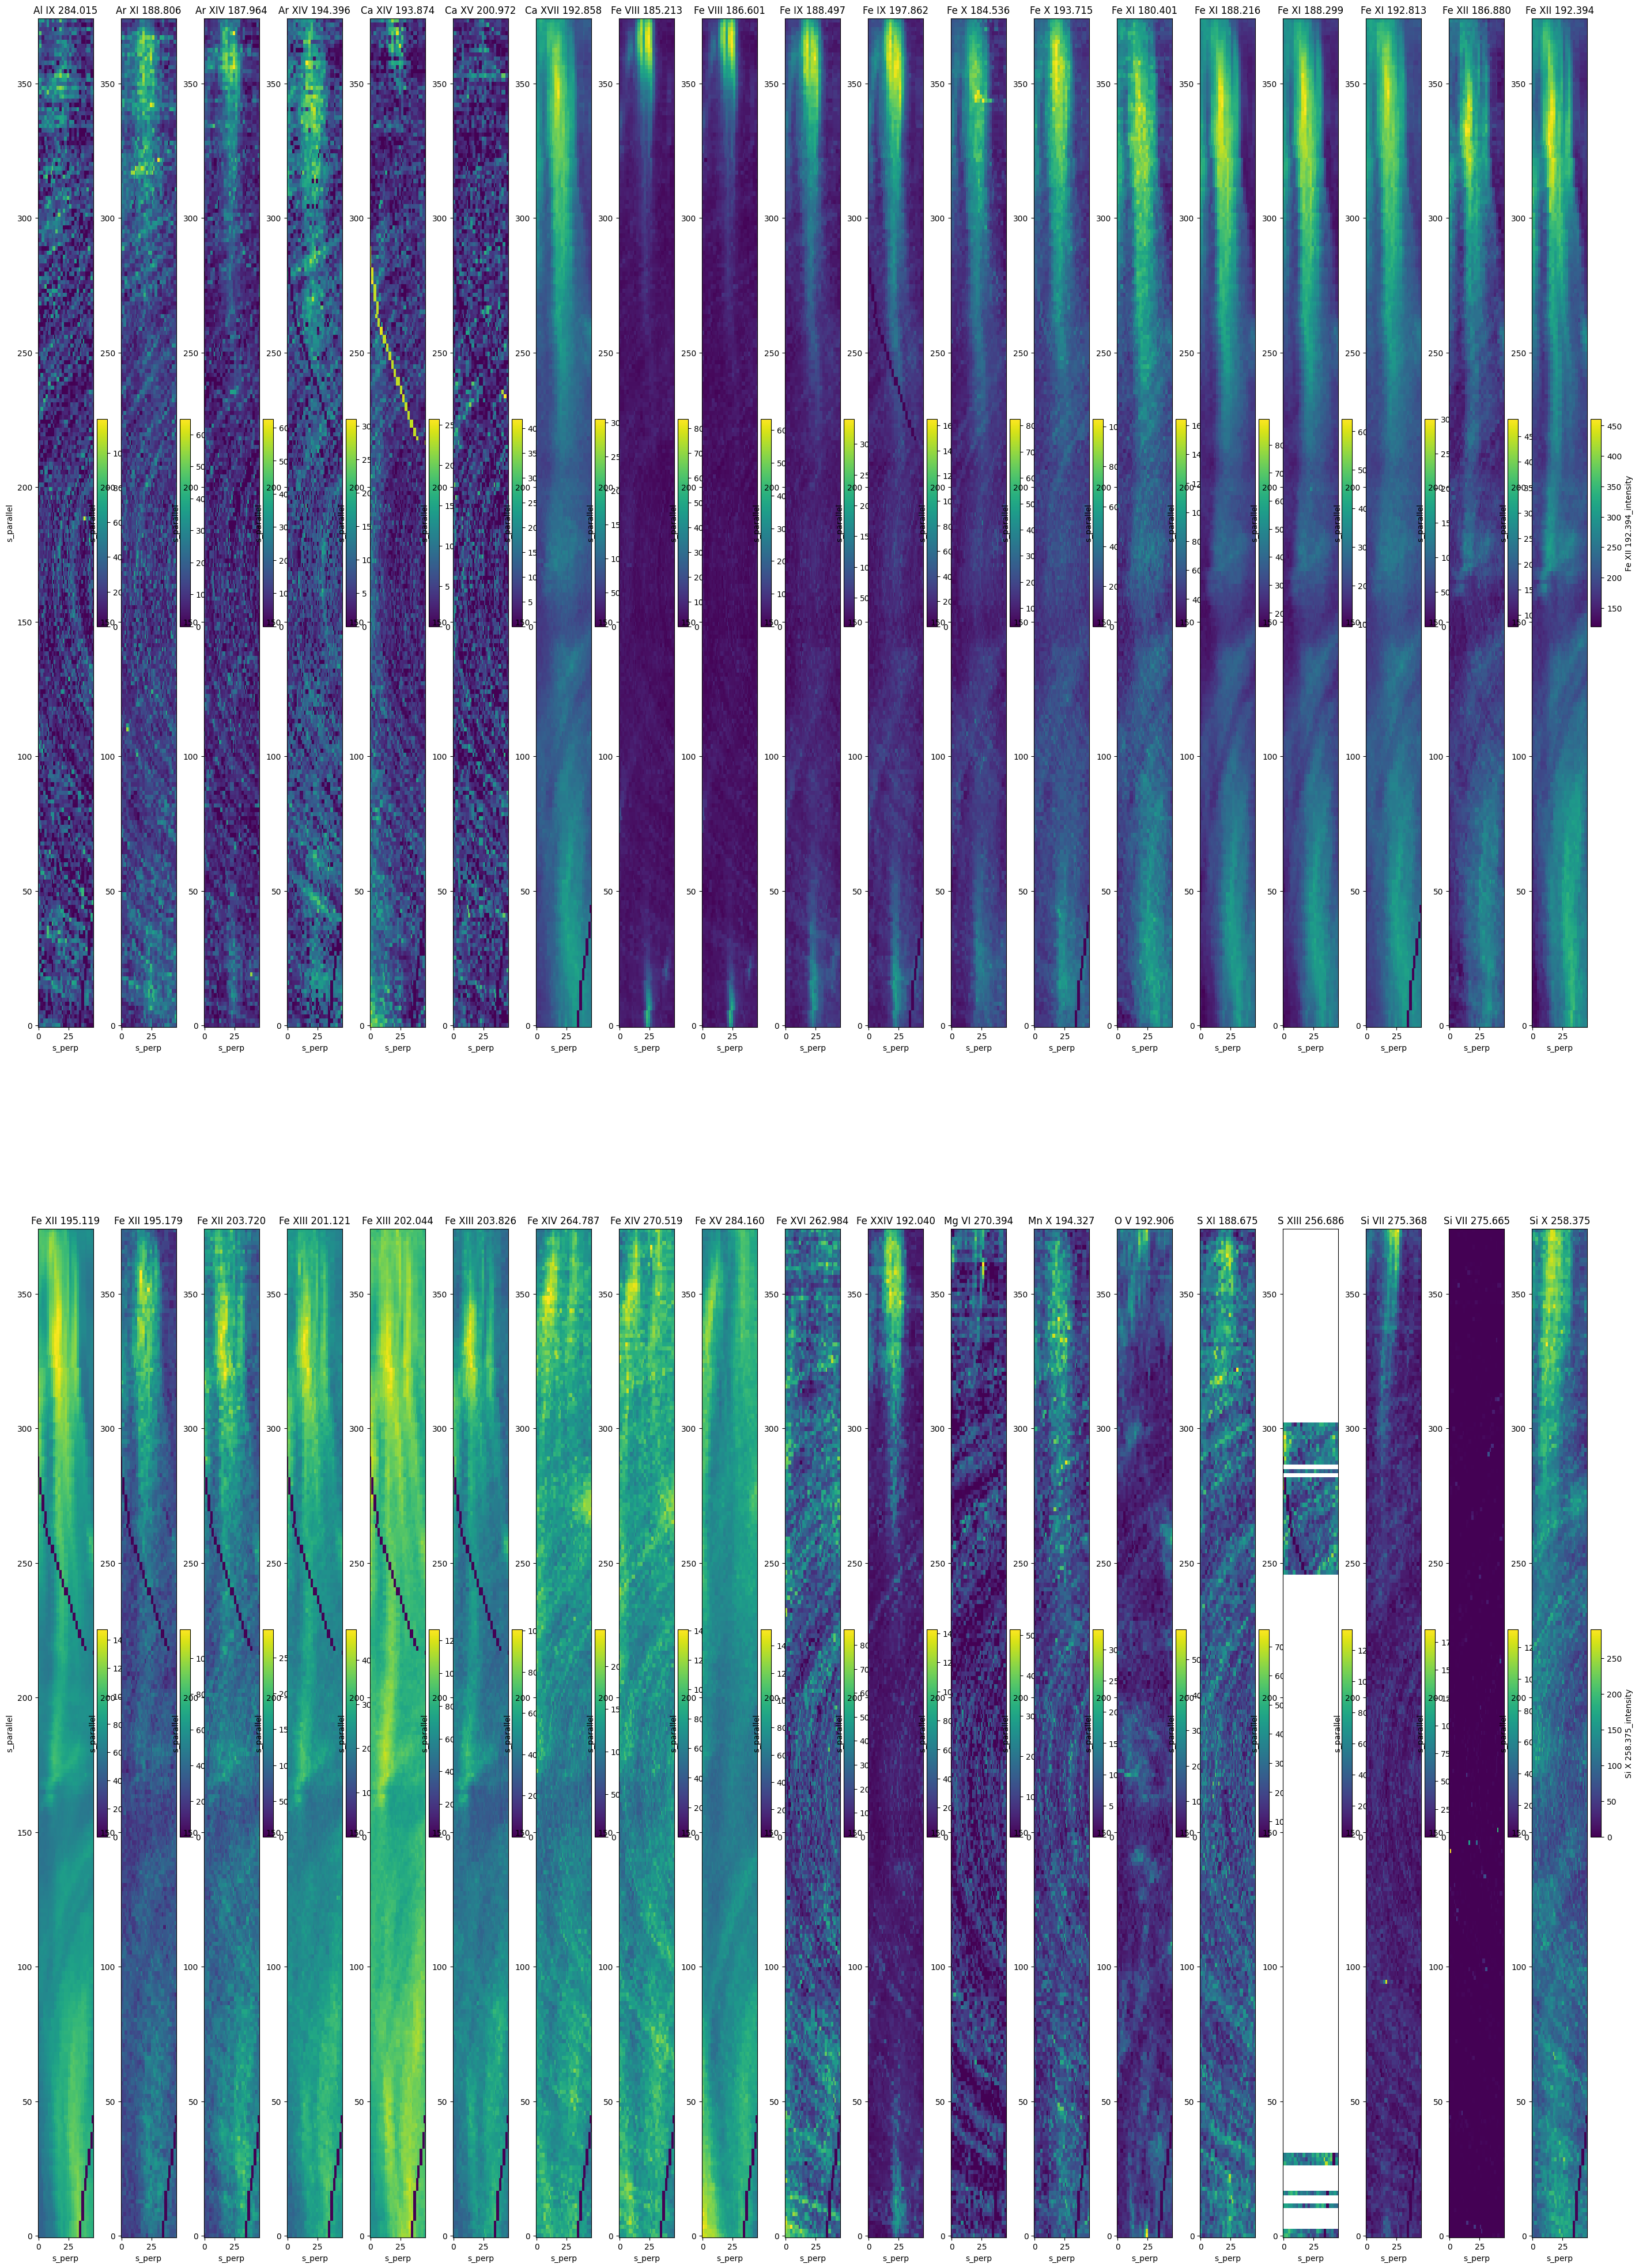

In [22]:
fig = plt.figure(figsize=(35, 50))
for i,k in enumerate([k for k in eis_ds.keys() if 'intensity' in k]):
    ax = fig.add_subplot(2, 19, i+1)
    eis_ds[k].plot.imshow(ax=ax)
    ax.set_title(k.split('_')[0])

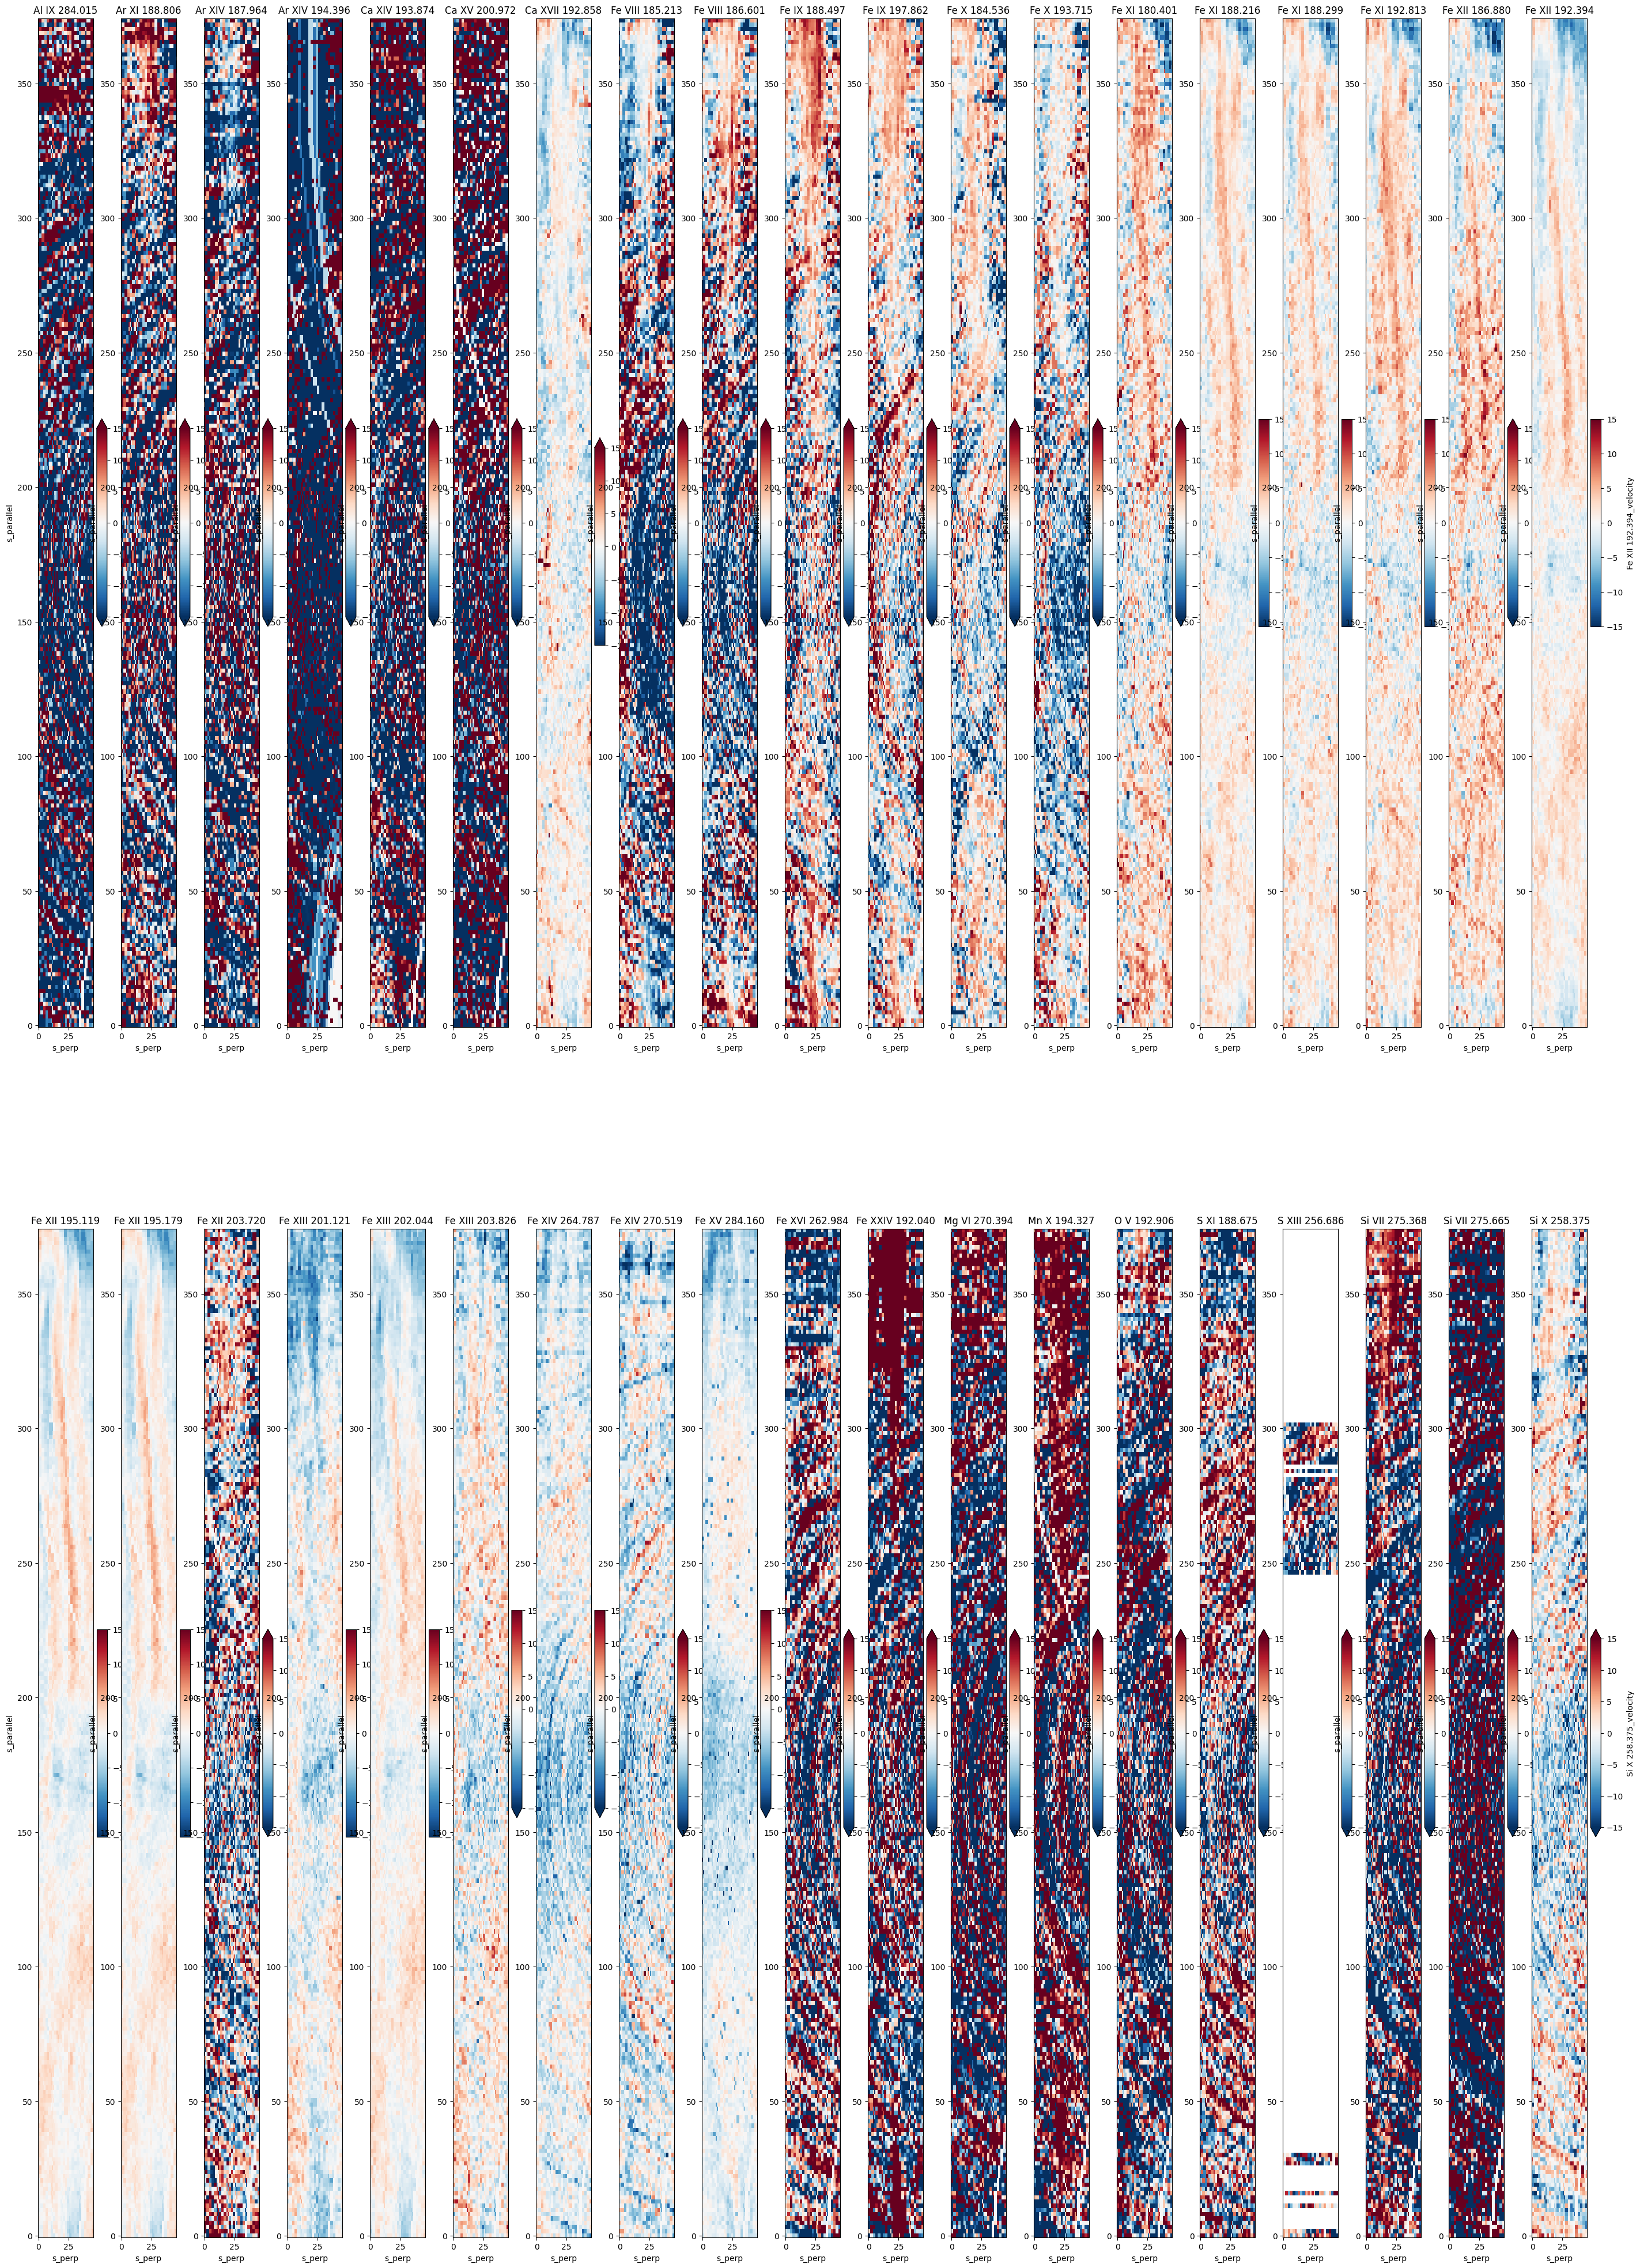

In [28]:
fig = plt.figure(figsize=(35, 50))
for i,k in enumerate([k for k in eis_ds.keys() if 'velocity' in k]):
    ax = fig.add_subplot(2, 19, i+1)
    eis_ds[k].plot.imshow(ax=ax, cmap='RdBu_r', vmin=-15, vmax=15)
    ax.set_title(k.split('_')[0])

In [31]:
fe12_195 = eis_ds['Fe XII 195.119_intensity']

In [32]:
data_filled = xarray.where(fe12_195 <= 0, np.nan, fe12_195).interpolate_na('s_perp').interpolate_na('s_parallel')
c1 = (data_filled[...,-1] - data_filled[...,0]) / (data_filled.s_perp[-1] - data_filled.s_perp[0]) 
c0 = data_filled[...,0] - c1 * data_filled.s_perp[0]
bg = c1 * data_filled.s_perp + c0

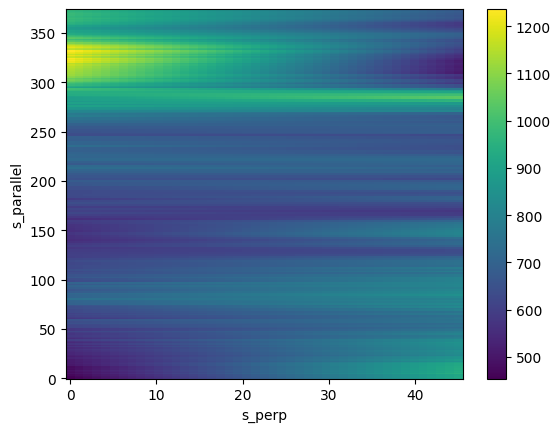

In [33]:
bg.plot()

In [34]:
fe12_195_no_bg = (fe12_195 - bg)
fe12_195_no_bg = xarray.where(fe12_195_no_bg<0, np.nan, fe12_195_no_bg)

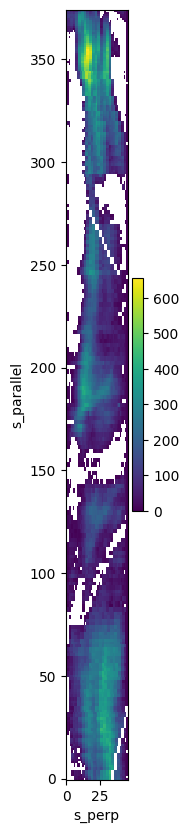

In [41]:
fig = plt.figure(figsize=(1,10))
ax = fig.add_subplot()
fe12_195_no_bg.plot(ax=ax)
#fe12_195.plot(aspect=0.2, size=8)

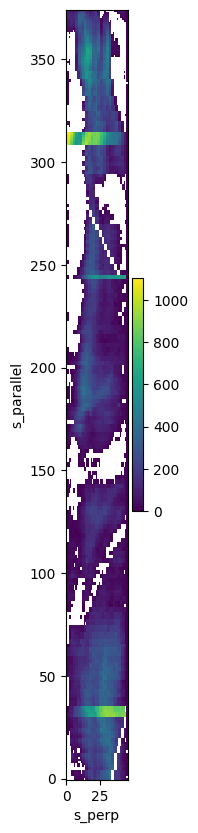

In [42]:
fig = plt.figure(figsize=(1,10))
ax = fig.add_subplot()
subtract_background(eis_ds['Fe XII 195.119_intensity']).plot(ax=ax)
#fe12_195.plot(aspect=0.2, size=8)

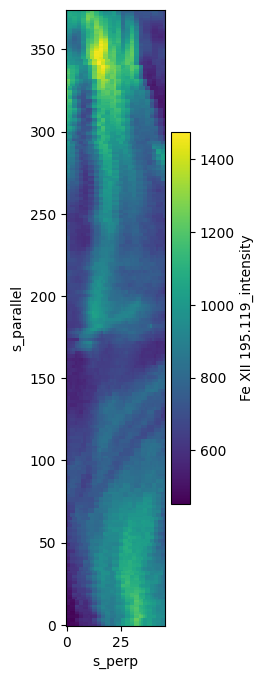

In [29]:
masked = xarray.where(fe12_195 <= 0, np.nan, fe12_195)
masked.interpolate_na('s_perp').interpolate_na('s_parallel').plot(aspect=0.2, size=8)
#min_s_perp = masked.min(skipna=True, dim='s_perp')

## AIA

In [5]:
aia_ds = xarray.open_dataset('../pipeline/data/AIA/loop_cutouts_no_background.nc')

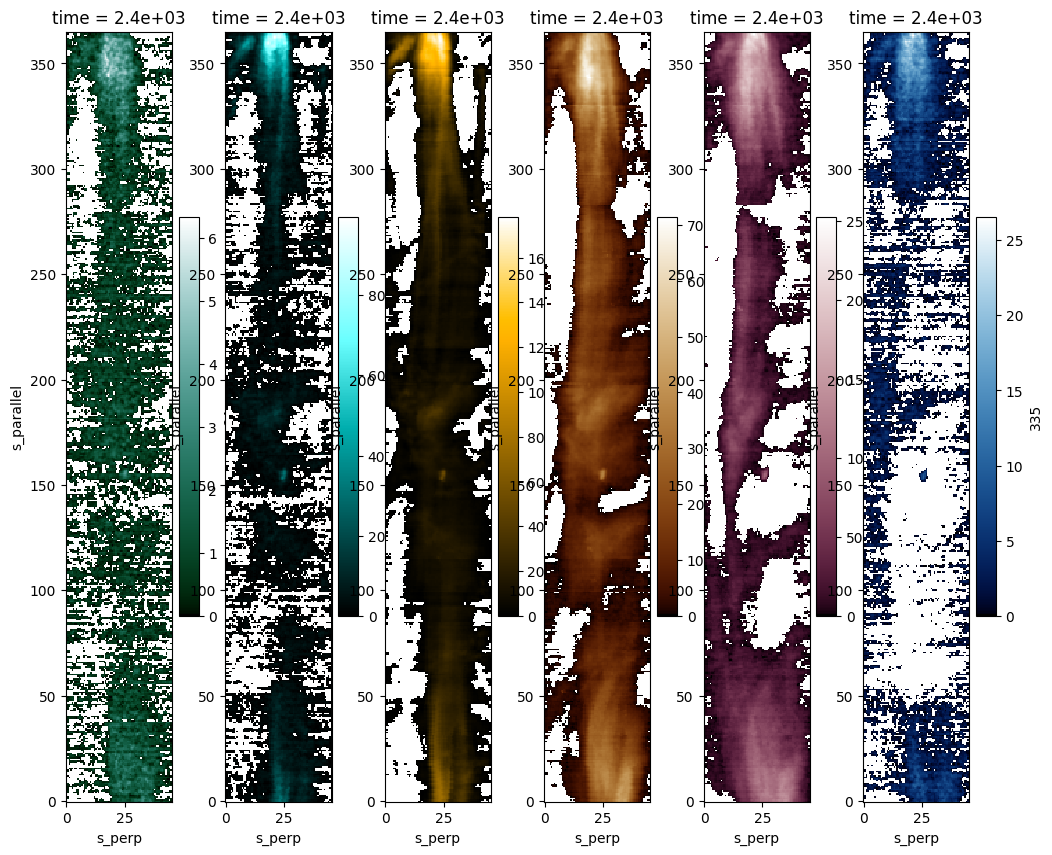

In [7]:
fig = plt.figure(figsize=(12, 10))
for i,channel in enumerate(['94', '131', '171', '193', '211', '335']):
    ax = fig.add_subplot(1,6,i+1)
    aia_ds[channel][10].plot.imshow(cmap=f'sdoaia{channel}', vmin=0, ax=ax)

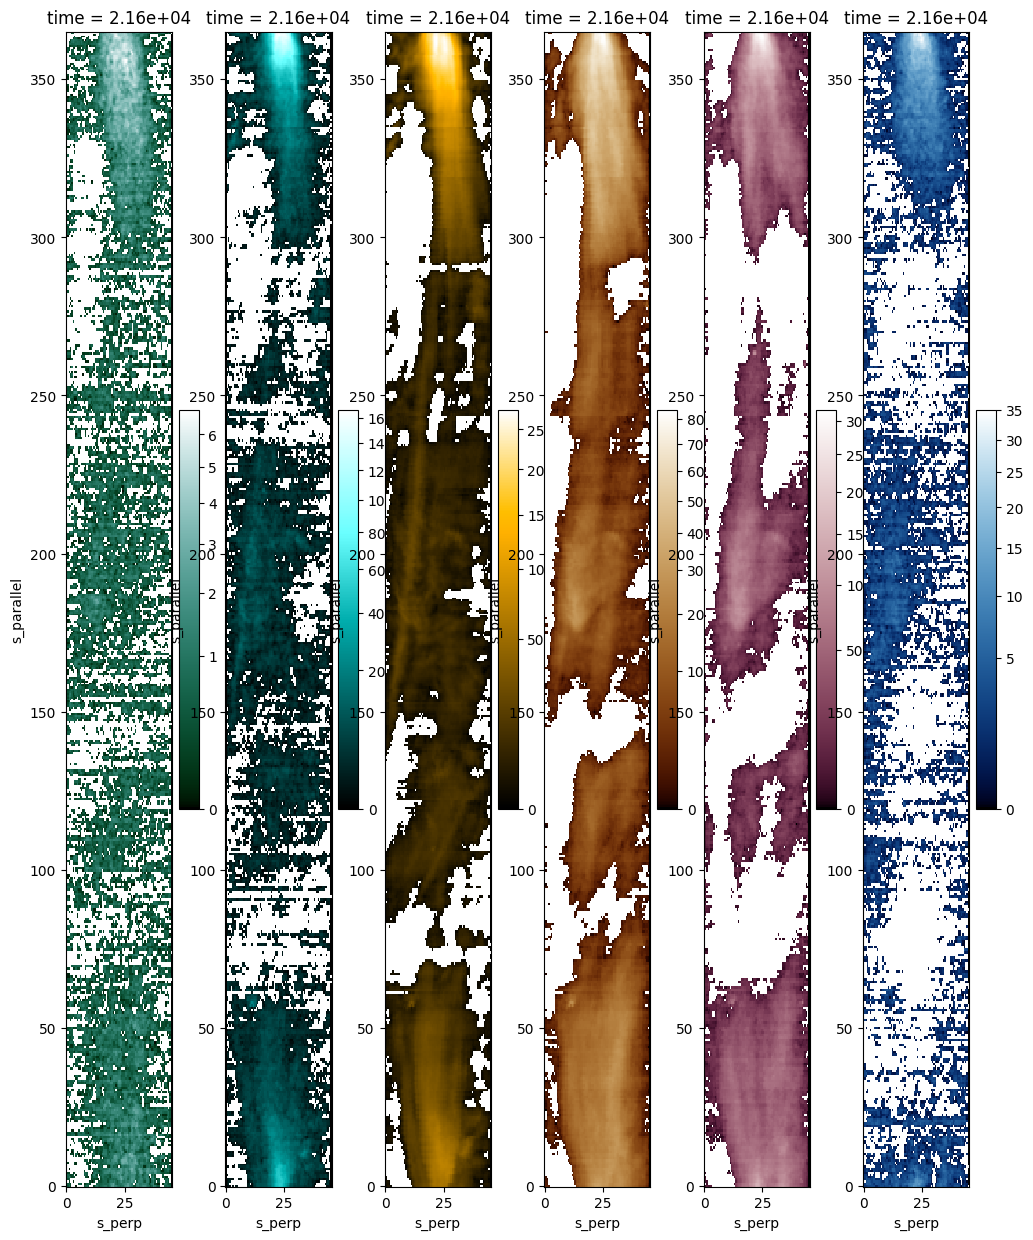

In [56]:
fig = plt.figure(figsize=(12, 15))
for i,channel in enumerate(['94', '131', '171', '193', '211', '335']):
    ax = fig.add_subplot(1,6,i+1)
    aia_ds_no_bg = subtract_background(aia_ds[channel], threshold=0.0)
    aia_ds_no_bg[90].plot(cmap=f'sdoaia{channel}', norm=ImageNormalize(stretch=SqrtStretch()),ax=ax)

In [50]:
aia_ds_no_bg = subtract_background(aia_ds['193'])
aia_ds_no_bg.hvplot(
    groupby="time",  # adds a widget for time
    clim=(0, 600),  # sets colormap limits
    #cnorm='log',
    widget_type="scrubber",
    widget_location="bottom",
    cmap='sdoaia171',
    aspect=0.2,
    height=600,
)

Column
    [0] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber')
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=179, width=550)

In [36]:
aia_ds['171'].hvplot(
    groupby="time",  # adds a widget for time
    clim=(0, 1000),  # sets colormap limits
    #cnorm='log',
    widget_type="scrubber",
    widget_location="bottom",
    cmap='sdoaia171',
    aspect=0.1,
    height=600,
)

Column
    [0] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber')
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=179, width=550)

In [57]:
aia_ds.keys()

KeysView(<xarray.Dataset>
Dimensions:     (s_parallel: 517, time: 180, s_perp: 77)
Coordinates:
  * s_parallel  (s_parallel) float64 0.0 0.6 1.449 2.049 ... 363.6 364.2 364.8
  * time        (time) float64 0.0 240.0 480.0 ... 4.248e+04 4.272e+04 4.296e+04
  * s_perp      (s_perp) float64 0.0 0.5921 1.184 1.776 ... 43.82 44.41 45.0
Data variables:
    94          (time, s_parallel, s_perp) float64 1.829 1.531 ... 2.789 2.238
    131         (time, s_parallel, s_perp) float64 7.487 7.975 ... 17.38 13.9
    171         (time, s_parallel, s_perp) float64 160.7 148.0 ... 606.8 464.9
    193         (time, s_parallel, s_perp) float64 274.7 270.9 ... 493.4 476.9
    211         (time, s_parallel, s_perp) float64 154.1 151.5 ... 186.9 181.8
    335         (time, s_parallel, s_perp) float64 24.43 23.43 ... 12.69 12.14)